# Figure 11: 

Contribution to the relative growth of difference potential enstrophy from the rotational and divergent flow as well as from total diabatic processes and cloud-radiative heating. Panel (a) is for the 310\,K isentrope, which is in the lower troposphere. Panel (b) is for the 326\,K isentrope, which is near the tropopause.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
import xarray as xr
import colorlegend
from matplotlib import ticker

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- Loading derived dataset from part 02

In [3]:
# loading datasets
# simulations
res = ['02_03']
#-------------------------------------
def load_simulations():
    ds_list = []
    for sim in list(res): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/pverrorgrowth/'
        # model output 'pv_icon' used for calculation
        fname1 = path+'pverror_diag_1x1_'+sim+'.nc'
        ds_var1 = xr.open_dataset(fname1)
        ds_var1.attrs['res'] = sim
        ds_list.append(ds_var1)
    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for 02_03


## 3- Functions

In [4]:
# functions
# gradient (center difference)
def grad(var,delta,ax):
    df = np.gradient(var,delta,axis=ax)
    return(df)

# center difference
def obs_cd(ds):

    obs_cd_np = grad(ds.dpe,3600,0) # 1 hourly output
    if ds.attrs['res'] == 'native':
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','ncells'))
    else:    
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','lev','lat','lon'))
    return(obs_cd_np_da)

# spatiall-average for a slab of isentropes
def spin(ds,var,lev1,lev2):
    dA = np.cos(np.deg2rad(45))
    dA = np.broadcast_to(dA.reshape((1, 1)), (len(ds.lat), len(ds.lon))).copy()
    dA /= dA.sum(axis=(0,1))
    #vertical sum
    si = (ds[var].sel(lev=slice(lev1,lev2)).sum('lev')*dA[None,:,:]).sum(axis=(1,2))
    return(si)

# spatial-average just for 1 level
def spin2(ds,var,lev1):
    dA = np.cos(np.deg2rad(45))
    dA = np.broadcast_to(dA.reshape((1, 1)), (len(ds.lat), len(ds.lon))).copy()
    dA /= dA.sum(axis=(0,1))
    #vertical sum
    si = (ds[var].sel(lev=lev1)*dA[None,:,:]).sum(axis=(1,2))
    return(si)

In [5]:
# common variables
lat  = ds_list[0].lat.values
lon  = ds_list[0].lon.values
time = ds_list[0].time
lev  = ds_list[0].lev
# deriving left hand side of the equation
ds_list[0]['ddtpv_ens'] = ds_list[0]['dpe'].diff(dim='time', label='upper')/3600
# or
ds_list[0]['ddtpv_ens_cd'] = obs_cd(ds_list[0])

## 4- Plot

In [6]:
# spatial integral
pver_1x1_326 = {}
pver_1x1_310 = {}
for var in ['ddtrhs','ddtrot','ddtdiv','ddtdia','ddtrad','ddtgsp','ddtmph','ddtcon',
            'ddtturb','ddtdrag','ddtdiff','ddtmom','ddtpv_ens_cd','dpe']:
    #pver_1x1[var] = spin(ds_list[0],var,320,330)
    pver_1x1_326[var] = spin2(ds_list[0],var,326)
    pver_1x1_310[var] = spin2(ds_list[0],var,310)

In [7]:
# relative growth of tendencies to the difference potential enstrophy
rproc_1x1_326 = {}
rproc_1x1_310 = {}
for var in ['ddtrhs','ddtrot','ddtdiv','ddtdia','ddtrad','ddtgsp','ddtmph','ddtcon',
            'ddtturb','ddtdrag','ddtdiff','ddtmom']:
    rproc_1x1_326[var] = pver_1x1_326[var]/pver_1x1_326['dpe']
    rproc_1x1_310[var] = pver_1x1_310[var]/pver_1x1_310['dpe']

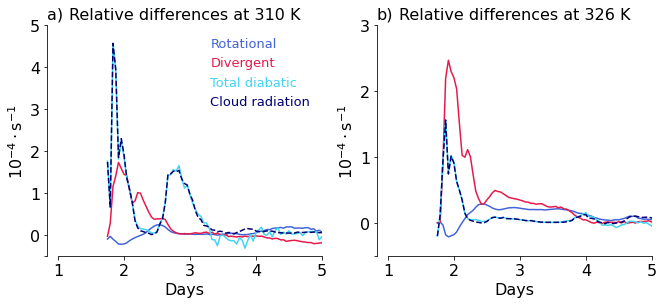

In [9]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 

xaxis = np.arange(0,217,1)
i = 0

for ax in axes.flat:
    
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelsize=16)
    
    ax.spines['bottom'].set_bounds(24,120)
    ax.set_xticks(np.arange(0,217,24))
    ax.set_xticklabels(["0","1", "2", "3", "4", "5","6","7","8","9"])
    ax.set_xlim([20, 120])
    
    if i == 1:
        
        im = ax.plot(rproc_1x1_326['ddtrot']*1e4,'#4363d8',label="Rotational",linewidth=1.5)
        im = ax.plot(rproc_1x1_326['ddtdiv']*1e4,'#e6194B',label="Divergent",linewidth=1.5)
        im = ax.plot(rproc_1x1_326['ddtdia']*1e4,'#42d4f4',label="Total diabatic",linewidth=1.5)
        im = ax.plot(rproc_1x1_326['ddtrad']*1e4,'#000075',label="Cloud radiation",linewidth=1.5,linestyle='--')
        
        ax.set_title('Relative differences at 326 K',fontsize=16) 
        ax.set_ylabel('$10^{-4} \cdot $s$^{-1}$',fontsize=16)
        ax.set_xlabel('Days',fontsize=16)
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=16)
        ax.spines['left'].set_bounds(-0.5,3)
        ax.set_yticks([-0.5,0,1,2,3])
        ax.set_yticklabels(["","0","1","2","3"])
        ax.set_ylim([-0.5,3])
        
    if i == 0:
        
        im = ax.plot(rproc_1x1_310['ddtrot']*1e4,'#4363d8',label="Rotational",linewidth=1.5)
        im = ax.plot(rproc_1x1_310['ddtdiv']*1e4,'#e6194B',label="Divergent",linewidth=1.5)
        im = ax.plot(rproc_1x1_310['ddtdia']*1e4,'#42d4f4',label="Total diabatic",linewidth=1.5)
        im = ax.plot(rproc_1x1_310['ddtrad']*1e4,'#000075',label="Cloud radiation",linewidth=1.5,linestyle='--')
       
        ax.set_title('Relative differences at 310 K',fontsize=16) 
        lg=colorlegend.color_legend(ax,fsize=13,loc='best')
        ax.set_ylabel('$10^{-4} \cdot $s$^{-1}$',fontsize=16)
        ax.set_xlabel('Days',fontsize=16)
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=16)
        ax.spines['left'].set_bounds(-0.5,5)
        ax.set_yticks([-0.5,0,1,2,3,4,5])
        ax.set_yticklabels(["","0","1","2","3","4","5"])
        ax.set_ylim([-0.5,5])

    i = i + 1     

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.3)   

plt.savefig('figure11.pdf', bbox_inches = 'tight')
#plt.savefig('figure11.png', bbox_inches = 'tight',dpi=100)